In [1]:
import sys
import os
import logging
from darts import concatenate
sys.path.insert(1, os.path.join(sys.path[0], '../../src'))
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [2]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
from datasets import ShellDataset, WeatherEcadDataset
from visualization import plot_time_series_predictions
from eval import evaluate, print_metrics_table

### Load Dataset

In [4]:
from datasets import BoulderDataset
dataset = BoulderDataset()
data = dataset.load(subset=None, chunk_length=365, min_chunk_length=365, na_threshold=0.1, select_last_only=True, split=0.8)

# Transform splits
target_scaler = Scaler(MinMaxScaler())
target_train = target_scaler.fit_transform(data['train'])
target_test= target_scaler.transform(data['test'])

Loaded 9 time series each with lengths [365, 365, 365, 365, 365, 365, 365, 365, 365]


In [5]:
print("Number of data points in target train, test: ", len(data['train'][0]),  len(data['test'][0]))

Number of data points in target train, test:  292 73


## Display Train / Test Series

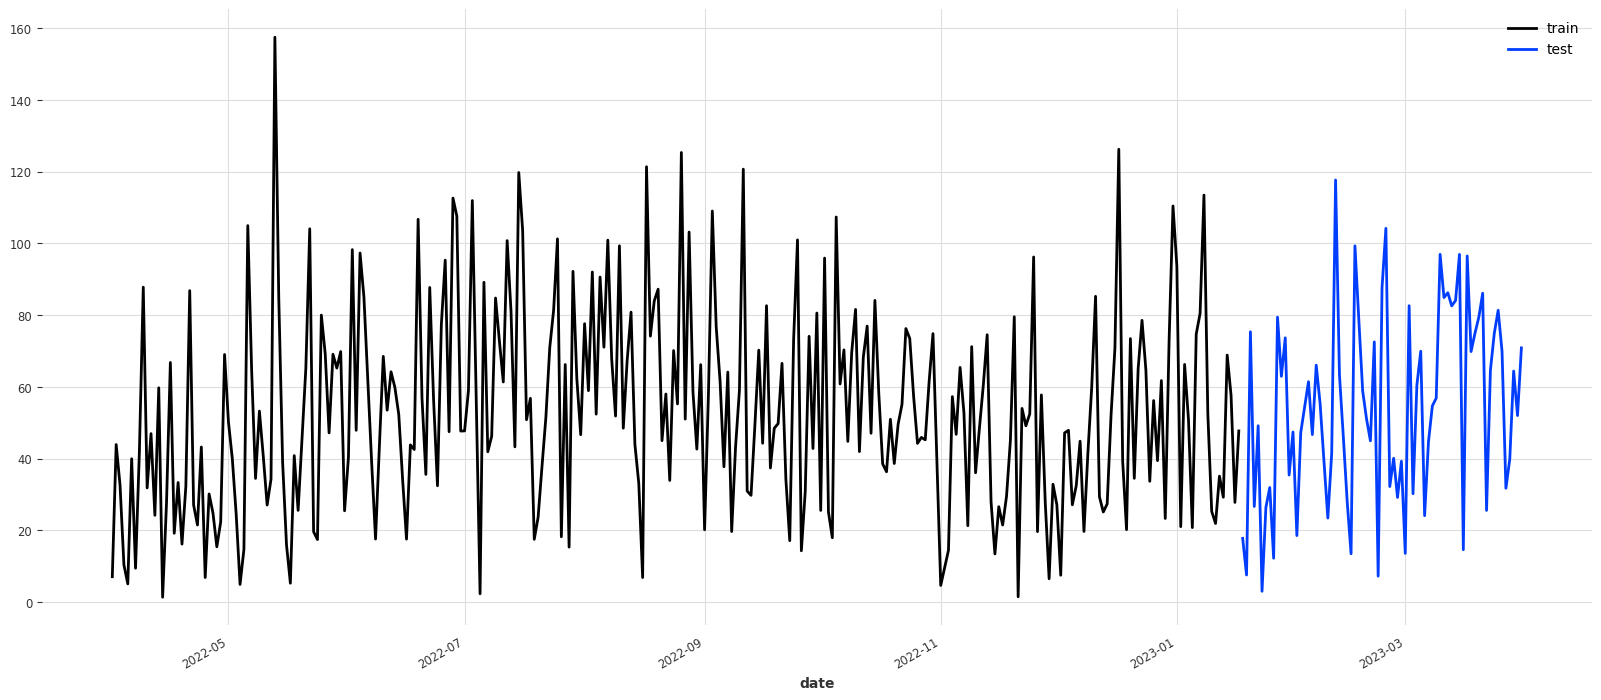

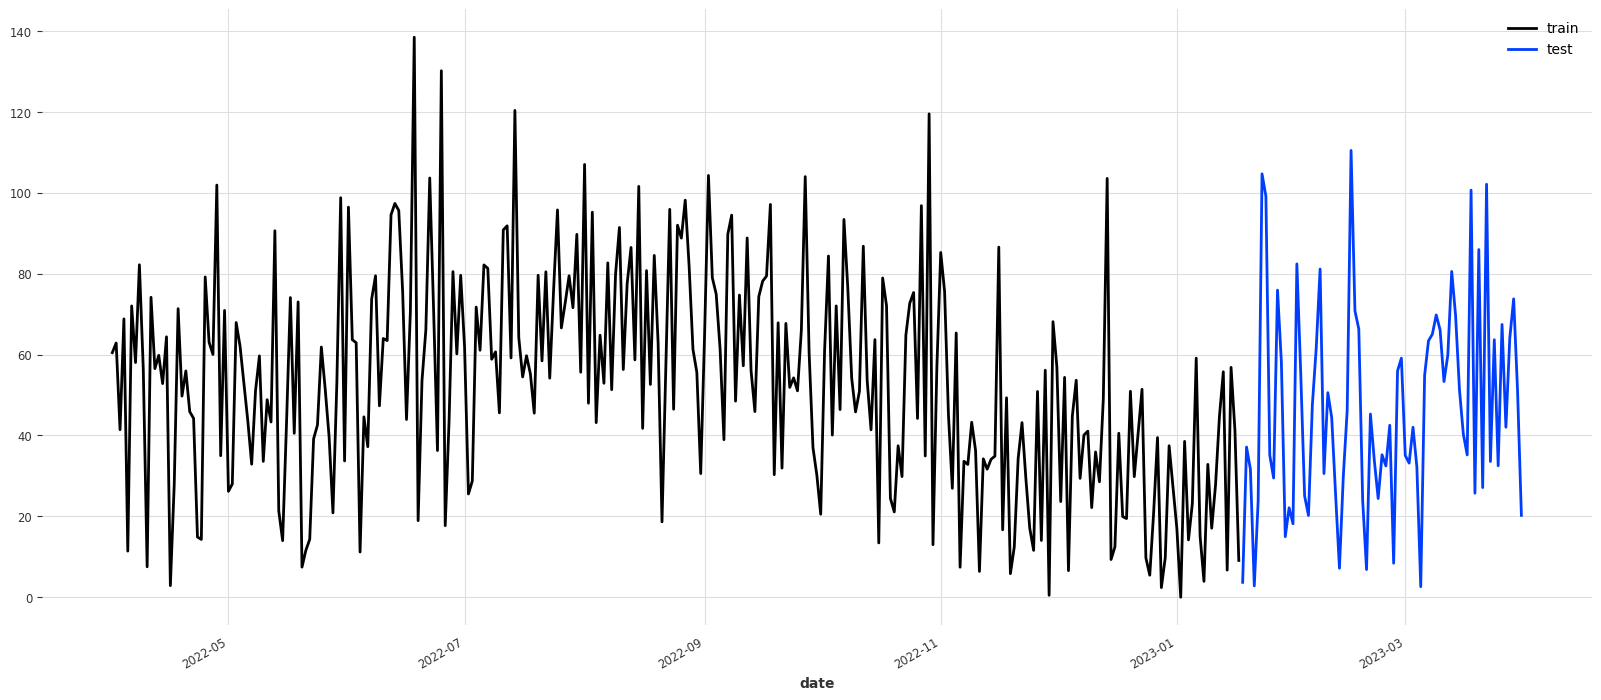

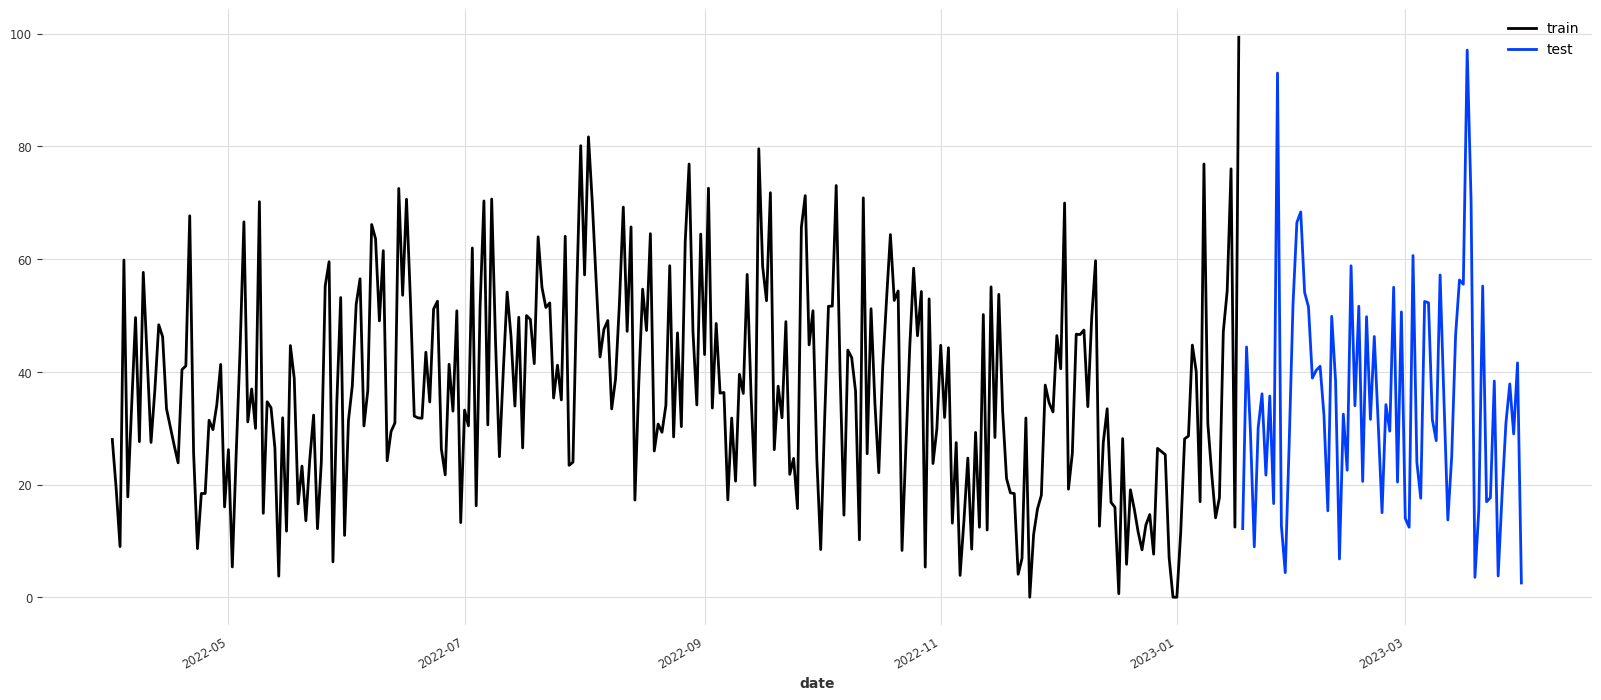

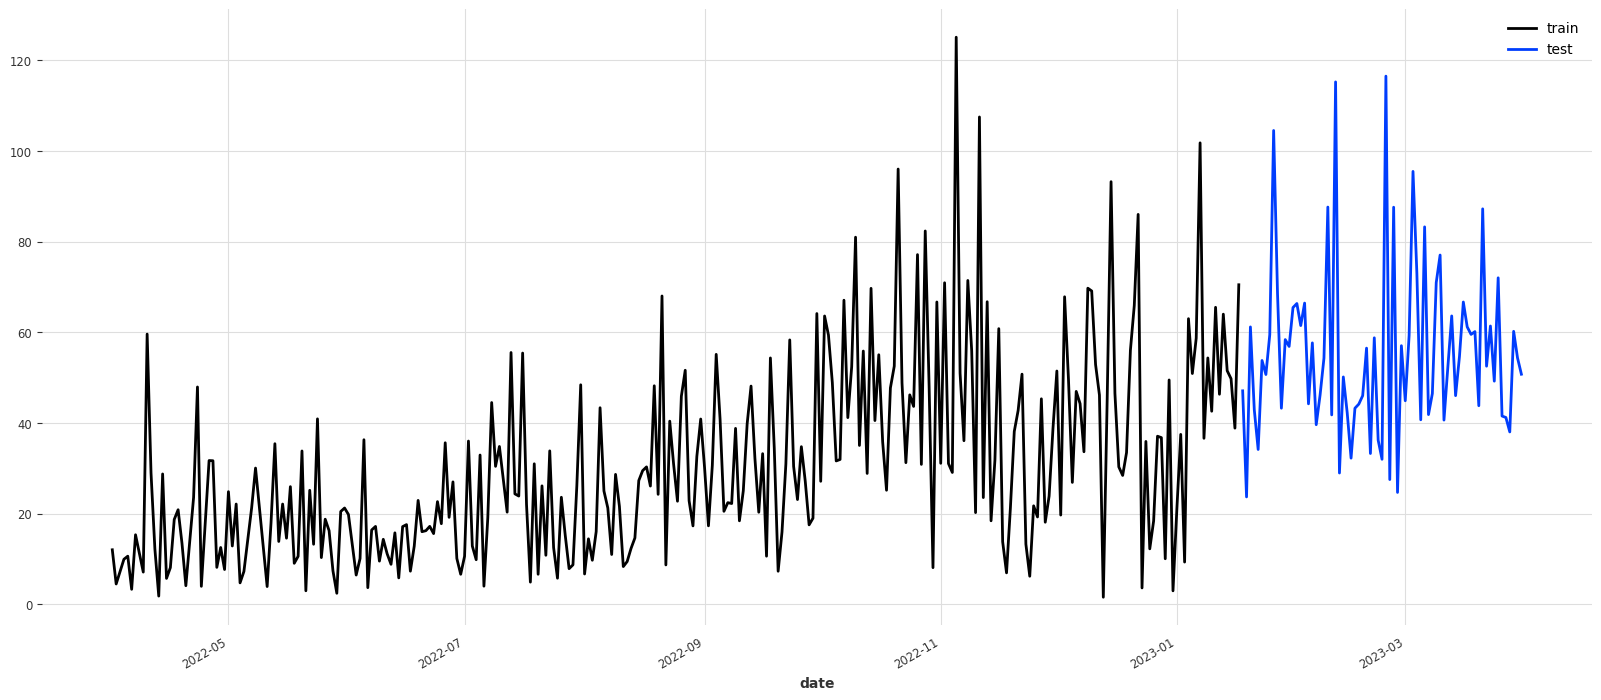

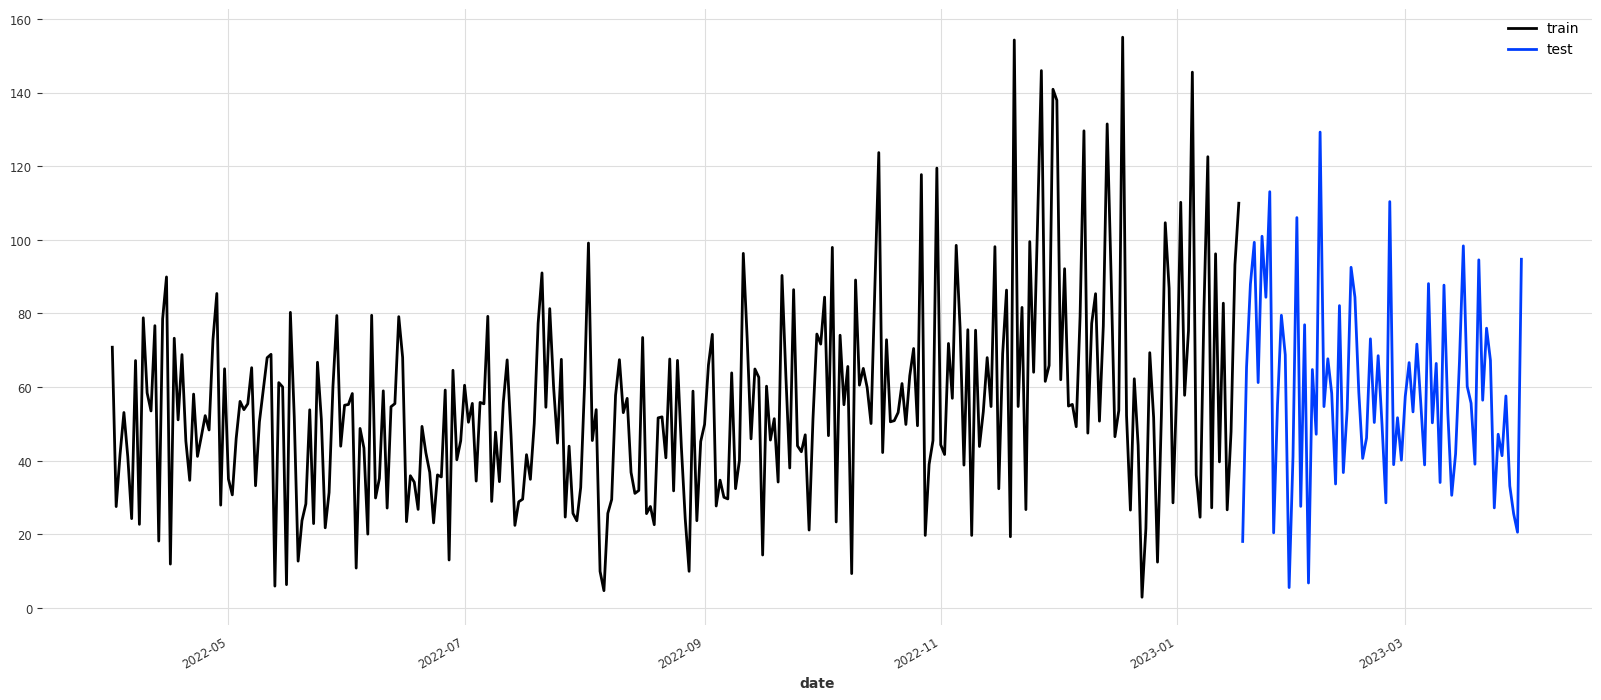

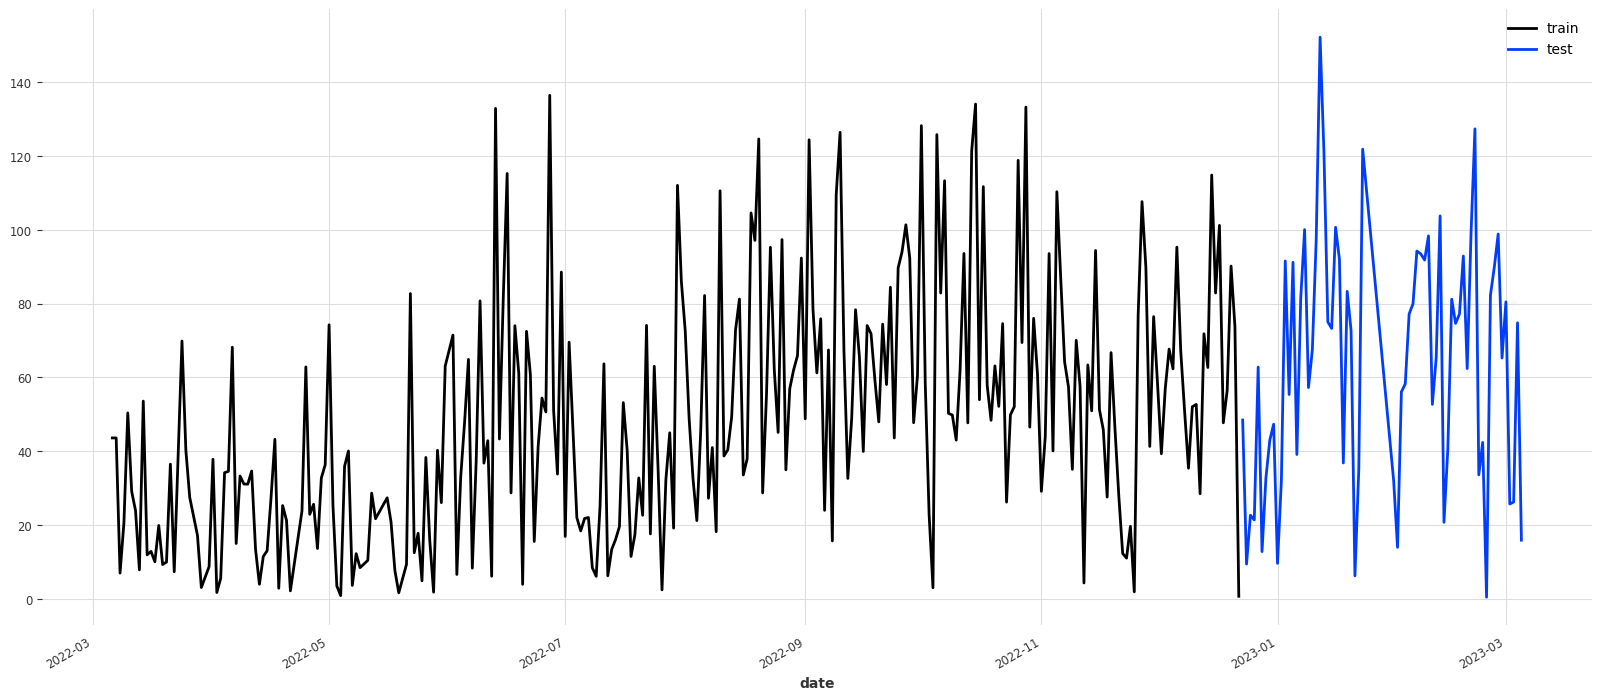

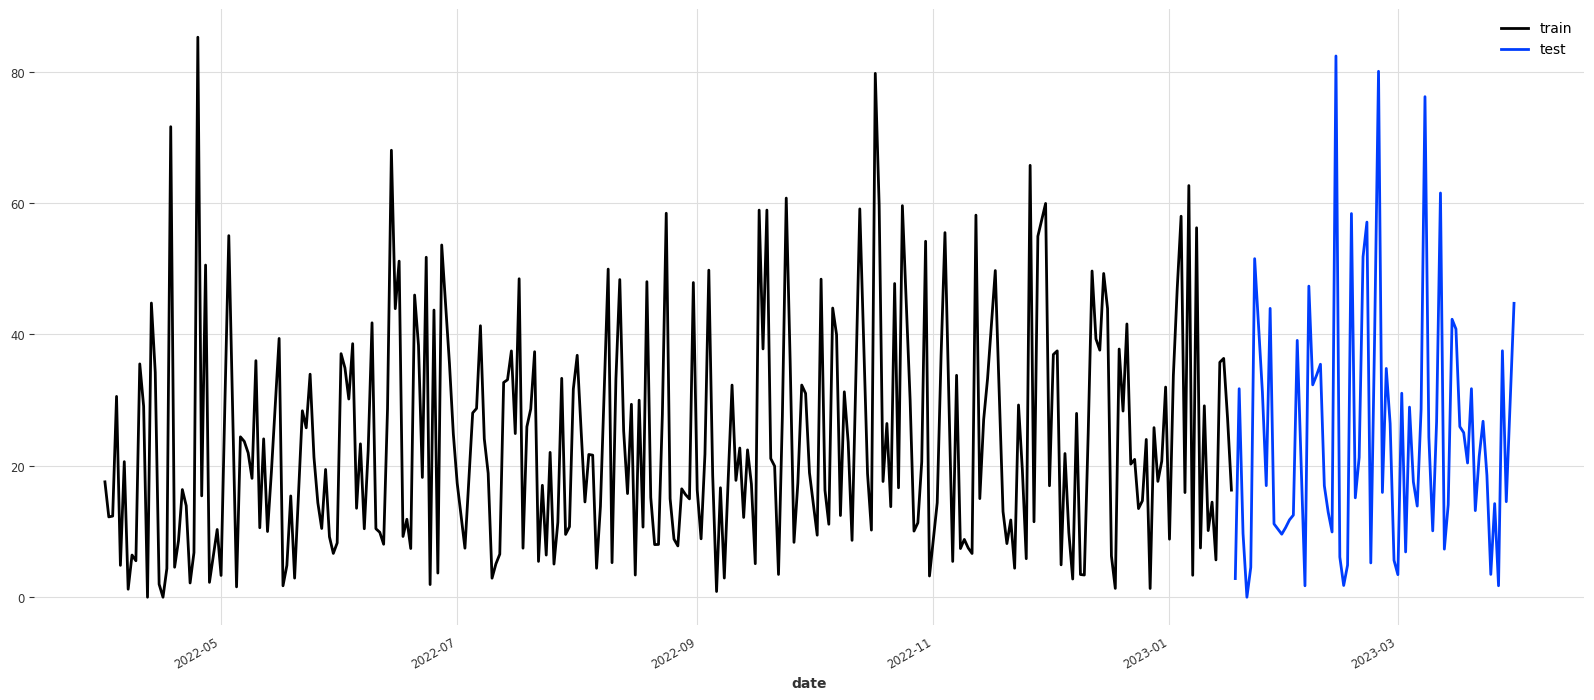

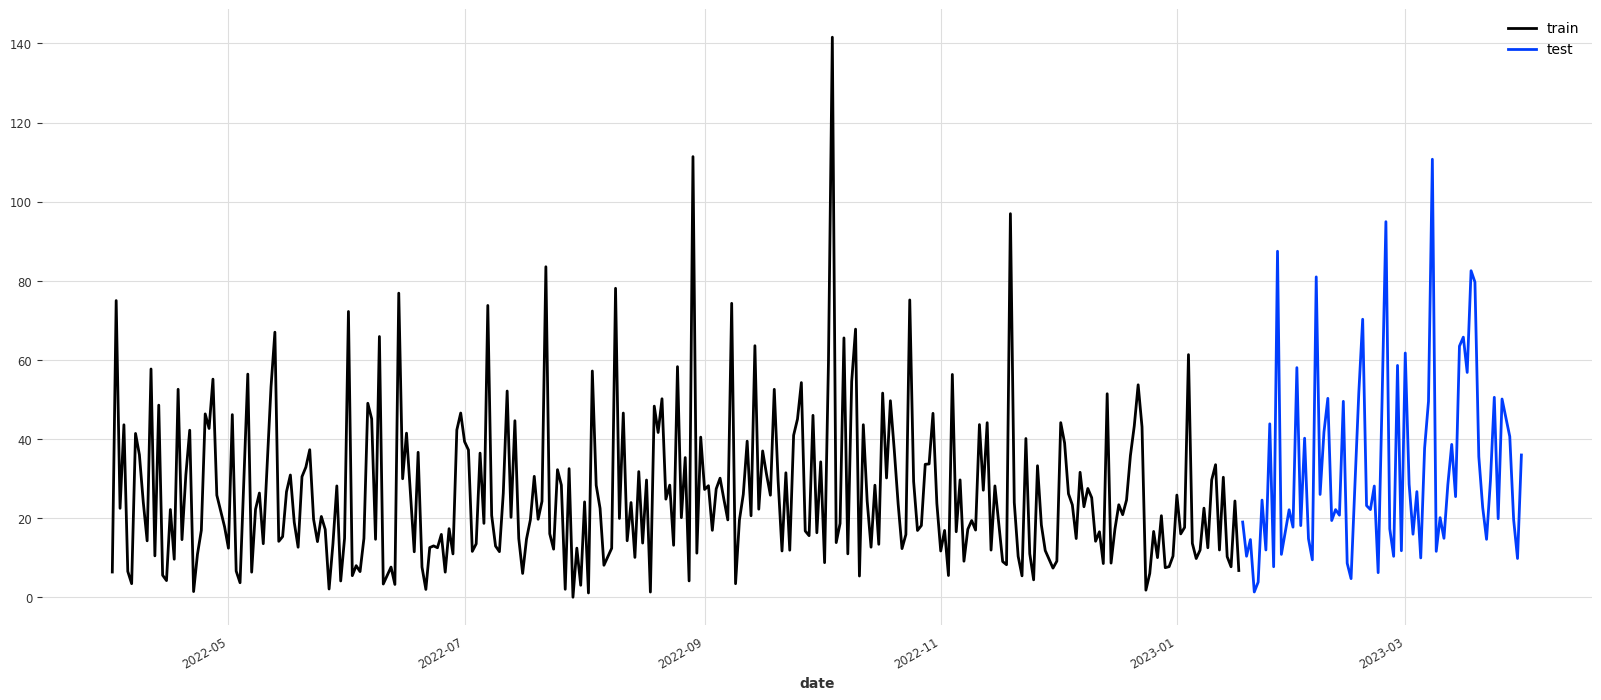

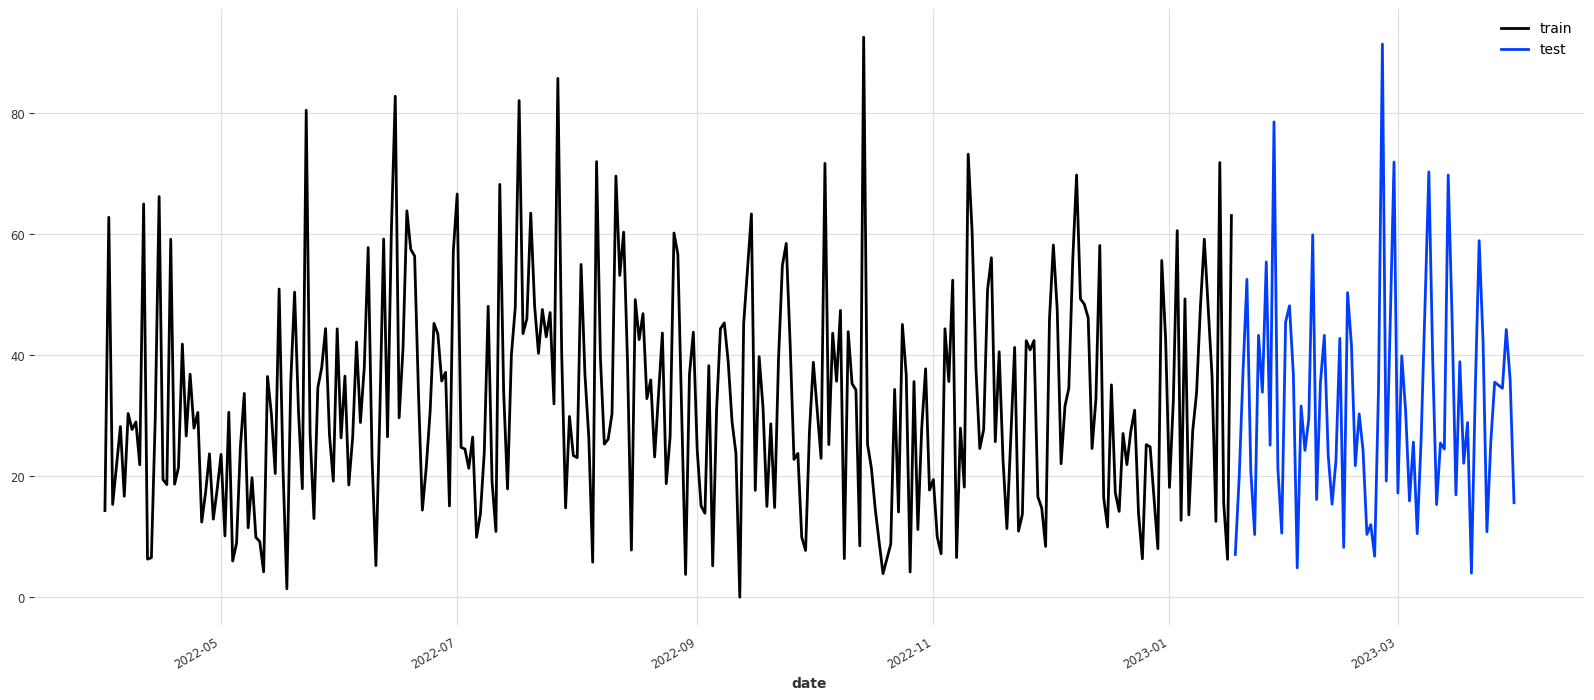

In [6]:
import matplotlib.pyplot as plt
for train, test in zip(data['train'], data['test']):
    plt.figure(figsize=(20, 8), dpi=100)
    train.plot(label='train')
    test.plot(label='test')
    plt.show()

### Set Experiment Parameters

In [7]:
FORECAST_HORIZON = 1
INPUT_CHUNK_LENGTH = 30

In [8]:
predictions = {}

# Baseline

In [9]:
from darts.models.forecasting.baselines import NaiveSeasonal, NaiveDrift, NaiveMean
def load_baselinemodel():
    return NaiveMean()

In [10]:
predictions_baseline = []
for target_train_single, target_test_single in zip(target_train, target_test):
    model = load_baselinemodel()

    model.fit(
        target_train_single,
    )

    forecast = model.historical_forecasts(
        series=concatenate([target_train_single, target_test_single]),
        start=target_test_single.start_time(),
        forecast_horizon=FORECAST_HORIZON,
        retrain=True
    )
    
    predictions_baseline.append(forecast)
predictions_baseline = target_scaler.inverse_transform(predictions_baseline)
predictions['Baseline'] = predictions_baseline

In [11]:
evaluate(predictions_baseline, data['test'])

{'MAPE': 53.02712713394166,
 'RMSE': 25.30443257392001,
 'MSE': 669.8362194766212,
 'MAE': 20.378780095266706}

# Local Training

#### ARIMA

In [12]:
def load_arimamodel():
    from darts.models import ARIMA
    return ARIMA(
        p=INPUT_CHUNK_LENGTH,
        d=0,
        q=INPUT_CHUNK_LENGTH
    )

In [13]:
%%capture
predictions_arima = []
for target_train_single, target_test_single in zip(target_train, target_test):
    model = load_arimamodel()

    model.fit(
        target_train_single,
    )

    forecast = model.historical_forecasts(
        series=concatenate([target_train_single, target_test_single]),
        start=target_test_single.start_time(),
        forecast_horizon=FORECAST_HORIZON,
        retrain=False
    )
    
    predictions_arima.append(forecast)
predictions_arima = target_scaler.inverse_transform(predictions_arima)
predictions['ARIMA'] = predictions_arima

In [14]:
evaluate(predictions_arima, data['test'])

{'MAPE': 66.62351200534,
 'RMSE': 27.401009148878376,
 'MSE': 778.2263182517136,
 'MAE': 21.671298924341965}

## Load encoder

In [15]:
from features.encoders import past_datetime_encoder, get_past_holiday_encoder

## NHITS

In [16]:
from darts.models import NHiTSModel

def load_nhitsmodel():
    return NHiTSModel(
        nr_epochs_val_period=1,
        input_chunk_length=INPUT_CHUNK_LENGTH,
        output_chunk_length=FORECAST_HORIZON,
        random_state=0,
        # add_encoders=past_datetime_encoder,
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [17]:
%%capture
predictions_nhits = []
for target_train_single, target_test_single in zip(target_train, target_test):
    target_train_single_train, target_train_single_val = target_train_single.split_after(0.7)

    model = load_nhitsmodel()

    model.fit(
        target_train_single_train,
        val_series=target_train_single_val,
    )

    forecast = model.historical_forecasts(
        series=concatenate([target_train_single, target_test_single]),
        start=target_test_single.start_time(),
        forecast_horizon=FORECAST_HORIZON,
        retrain=False
    )
    
    predictions_nhits.append(forecast)
predictions_nhits = target_scaler.inverse_transform(predictions_nhits)
predictions['NHiTS (Local)'] = predictions_nhits

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 858 K 
---------------------------------------------------
843 K     Trainable params
15.4 K    Non-trainable params
858 K     Total params
3.435     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: Fals

In [18]:
evaluate(predictions_nhits, data['test'])

{'MAPE': 48.12527574070664,
 'RMSE': 24.89175372142068,
 'MSE': 639.7642053954903,
 'MAE': 19.620712180920645}

# Global Training

In [19]:
def train_global_model(model, target_train, target_test,  target_scaler, forecast_horizon, train_split=0.7):
    target_train_train, target_train_val = [], []
    for target_train_single in target_train:
        target_train_train_single, target_train_val_single = target_train_single.split_after(train_split)
        target_train_train.append(target_train_train_single)
        target_train_val.append(target_train_val_single)

    model.fit(
        series=target_train_train,
        val_series=target_train_val,
    )

    predictions = []
    for target_train_single, target_test_single in zip(target_train, target_test):
        forecast = model.historical_forecasts(
            series=concatenate([target_train_single, target_test_single]),
            start=target_test_single.start_time(),
            forecast_horizon=forecast_horizon,
            retrain=False
        )
        predictions.append(forecast)
    predictions = target_scaler.inverse_transform(predictions)
    return model, predictions

# TFT

In [20]:
from darts.models import TFTModel

def load_tftmodel():
    return TFTModel(
        nr_epochs_val_period=1,
        input_chunk_length=INPUT_CHUNK_LENGTH,
        output_chunk_length=FORECAST_HORIZON,
        # add_encoders=add_encoders,
        random_state=0,
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [21]:
# %%capture

# tft_model = load_tftmodel()
# tft_model_fit, predictions_tft_global = train_global_model(tft_model, target_train, target_test, covariates_train, covariates_test, target_scaler, FORECAST_HORIZON, train_split=0.7)

# predictions['TFT Global'] = predictions_tft_global


In [22]:
# evaluate(predictions_tft_global, data['test'])

In [24]:
%%capture
nhits_model = load_nhitsmodel()
nhits_model_fit, predictions_nhits_global = train_global_model(nhits_model, target_train, target_test, target_scaler, FORECAST_HORIZON, train_split=0.7)

predictions['NHiTS (Global)'] = predictions_nhits_global


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 858 K 
---------------------------------------------------
843 K     Trainable params
15.4 K    Non-trainable params
858 K     Total params
3.435     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: Fals

In [25]:
evaluate(predictions_nhits_global, data['test'])

{'MAPE': 46.17803309576034,
 'RMSE': 25.49761803579271,
 'MSE': 672.2376988086626,
 'MAE': 20.630401715151756}

In [ ]:
model.save('../../models/nhits_model_shell_4.pt')

# Results

In [ ]:
evaluate(predictions_nhits, data['test'])

In [ ]:
plot_time_series_predictions(predictions, data['test'], FORECAST_HORIZON)

## Metrics

In [26]:
for model, predictions in predictions.items():
    results = evaluate(predictions, data['test'])
    print(f"Model:", model, results)

Model: Baseline {'MAPE': 53.02712713394166, 'RMSE': 25.30443257392001, 'MSE': 669.8362194766212, 'MAE': 20.378780095266706}
Model: ARIMA {'MAPE': 66.62351200534, 'RMSE': 27.401009148878376, 'MSE': 778.2263182517136, 'MAE': 21.671298924341965}
Model: NHiTS (Local) {'MAPE': 48.12527574070664, 'RMSE': 24.89175372142068, 'MSE': 639.7642053954903, 'MAE': 19.620712180920645}
Model: NHiTS (Global) {'MAPE': 46.17803309576034, 'RMSE': 25.49761803579271, 'MSE': 672.2376988086626, 'MAE': 20.630401715151756}
